### We can construct a mosaic of nearby tiles using this method: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36738

# Import Necessary Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input, Dense, Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
import math
from PIL import Image

C:\Users\notda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\notda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\notda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\notda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
np.version.version

'1.22.1'

# Defining Constants

In [3]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 256
MODEL_BATCH_SIZE = 32
KERNEL_SIZE = 3
IMG_DIMS = 256
EPOCHS = 32
DATA_PATH = 'data/train-jpg/'

# Preprocess data
---

### Obtain Labels

In [4]:
train_data = pd.read_csv('data/train_v2.csv')

curr_count = 0
unique_labels = {}
multihot = {}
for line in train_data['tags'].values:
    for label in line.split():
        if label not in unique_labels:
            unique_labels[label] = curr_count
            curr_count += 1

mapping = {}

n_labels = len(unique_labels)

for k, v in unique_labels.items():
    mapping[k] = np.zeros(n_labels, dtype=np.float16)
    mapping[k][v] = 1.0
    mapping[k] = tf.constant(mapping[k])


label2name = {v: k for k, v in unique_labels.items()}

print(label2name)

{0: 'haze', 1: 'primary', 2: 'agriculture', 3: 'clear', 4: 'water', 5: 'habitation', 6: 'road', 7: 'cultivation', 8: 'slash_burn', 9: 'cloudy', 10: 'partly_cloudy', 11: 'conventional_mine', 12: 'bare_ground', 13: 'artisinal_mine', 14: 'blooming', 15: 'selective_logging', 16: 'blow_down'}


### View Head of dataset

In [5]:
train_data.head(n = 11)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


### Auxiliary Function for multi-hotting

In [7]:
def multihot(label_tensor):
    label_string = label_tensor.decode("utf-8")
    label = tf.zeros([n_labels], dtype=tf.float16)
    tokens = label_string.split(' ')

    for k in range(len(tokens)):
        label += mapping[tokens[k]]

    return label

### Auxiliary function for converting tensor filename to image

In [ ]:
def readImage(filename_tensor, resize = [IMG_DIMS, IMG_DIMS]):
    full_path = DATA_PATH + filename_tensor.decode("utf-8") + '.jpg'

    img = Image.open(full_path).convert("RGB")
    img = np.asarray(img) / 255
    img = tf.convert_to_tensor(img)
    img = tf.image.resize(img, resize)

    return img

### Function to grab the label from the filename

In [8]:
def symbolicRealMapping(filename_tensor, label_tensor):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """

    img = tf.numpy_function(readImage, [filename_tensor], tf.float32)
    label_multihot = tf.numpy_function(multihot, [label_tensor], tf.float16)

    # # print(f"{img = }")

    return img, label_multihot

### Create the spanning dataset

In [9]:
# first pass, construct a list of image strips

file_paths = train_data['image_name'].values
labels_strings = train_data['tags'].values
spanning_dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels_strings))
spanning_dataset = spanning_dataset.map(symbolicRealMapping)
dataset_length = len(spanning_dataset)
print(f"{dataset_length}")

40479


### Split into a test and train set, batch each

In [10]:
train_length = math.floor(0.8 * dataset_length)
train_ds, val_ds = spanning_dataset.take(train_length).batch(TRAIN_BATCH_SIZE), spanning_dataset.skip(train_length).batch(TEST_BATCH_SIZE)

### Display a target image

In [70]:
def show_image(idx, X, y):
    img = tf.cast(X[idx] * 255, tf.uint8)
    # print(f"{img = }")
    indices = tf.where(y[idx] == 1).numpy()
    label_arr = []
    for index in indices:
        label_arr.append(label2name[index[0]])
    label = ' '.join(label_arr)
    plt.imshow(img)
    plt.title(label)
    plt.show()

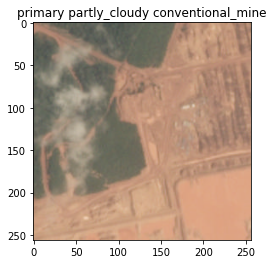

In [72]:
batch = None

for e in train_ds:
    batch = e
    break

show_image(24, batch[0], batch[1])

# Prepare the model
---

### Define evaluation function

In [ ]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

### Model Architecture

In [ ]:
ds_model = Sequential()

ds_model.add(Conv2D(filters = 28,
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE),
    input_shape = (IMG_DIMS, IMG_DIMS, 3),
    activation='relu',
    padding = 'Same'))
ds_model.add(MaxPooling2D(pool_size = (2, 2)))

ds_model.add(Conv2D(filters = 28,
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE),
    activation='relu'))
ds_model.add(MaxPooling2D(pool_size = (2, 2)))

ds_model.add(Conv2D(filters = 28,
    kernel_size = (KERNEL_SIZE, KERNEL_SIZE),
    activation='relu'))
ds_model.add(MaxPooling2D(pool_size = (2, 2)))

ds_model.add(Flatten())

ds_model.add(Dense(200, activation = 'relu'))
ds_model.add(Dropout(0.2))

ds_model.add(Dense(100, activation = 'relu'))
ds_model.add(Dropout(0.1))

ds_model.add(Dense(n_labels, activation = 'sigmoid'))

### Compile the model

In [ ]:
opt = K.optimizers.Adam(learning_rate=0.01)

ds_model.compile(optimizer=opt,
    loss = 'binary_crossentropy',
    metrics=[macro_f1])

# Train model
---

In [ ]:
ds_history = ds_model.fit(train_ds,
    epochs = EPOCHS,
    batch_size = MODEL_BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1)

# View results
---

### Store the history in a dataframe

In [ ]:
history_df = pd.DataFrame(ds_history.history)
history_df

### Plotting the loss

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
history_df['loss'].plot(label='Training Loss')
history_df['val_loss'].plot(label='Validation loss')
plt.legend(loc='center')

### Grabbing the first batch

In [ ]:
batch0 = None
for batch in train_ds:
    batch0 = batch
    break

# NOTE: Batch1 is a TUPLE, not a tensor.
# It's comprised of two separate tensors, where the first
# element is the set of feature tensors of dimension 64x256x256x3
# because each batch is comprised of 64 elements, each being
# 256x256x3 images.
# The second element in the tuple is the tensor of multihot encodings

print(f"{batch0 = }")

In [ ]:
y_hat_probs = ds_model.predict(batch0[0])

In [ ]:
y_hat_probs[240]